### Importing the Libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     RandomizedSearchCV, 
                                     GridSearchCV)

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             RocCurveDisplay,
                             precision_recall_curve, 
                             average_precision_score,
                             roc_auc_score, 
                             roc_curve, auc)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Establishing the connection to the Database

In [5]:
dbname = 'loan_management'
user = 'postgres'
password = 'simi280498'
host = '127.0.0.1'
port = '5432'

In [6]:
#Establishing the connection
engine = create_engine(f'postgresql://{user}:{password}@{host}/{dbname}')

### Extracting the data from the tables

In [8]:
# Define your SELECT query
query = '''SELECT * FROM borrower as b 
         inner join loan_to_income as lti 
         on b.borrower_id = lti.borrower_id 
         inner join loan as l
         on lti.loan_id = l.loan_id'''

In [9]:
df = pd.read_sql_query(query, engine)
print("Data loaded successfully!")

Data loaded successfully!


### Closing the connection

In [11]:
engine.dispose()

### Separating Features and Target Value

In [13]:
df.head()

,borrower_id,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,education,employment_type,marital_status,...,has_cosigner,loan_id,borrower_id,loan_amount_to_income,loan_id,loan_amount,interest_rate,loan_term,loan_purpose,defaulter
0,BZOPZLF57NR,67,77135,529,59,4,0.41,High School,Full-time,Married,...,0,ZOPZLF57NR,BZOPZLF57NR,2.072198,ZOPZLF57NR,159839,4.14,36,Other,0
1,BPNRE399EUV,54,74954,635,59,4,0.40,Bachelor's,Unemployed,Single,...,1,PNRE399EUV,BPNRE399EUV,3.231262,PNRE399EUV,242196,9.05,36,Education,0
2,BTNHNNVH282,52,96409,577,93,1,0.65,Master's,Unemployed,Married,...,1,TNHNNVH282,BTNHNNVH282,1.499487,TNHNNVH282,144564,21.20,36,Education,0
3,B4066OHTN9A,61,134076,602,6,2,0.84,Master's,Unemployed,Divorced,...,1,4066OHTN9A,B4066OHTN9A,1.050785,4066OHTN9A,140885,22.89,60,Other,0
4,BF50KOUWNHK,57,97979,497,43,4,0.65,Master's,Full-time,Married,...,0,F50KOUWNHK,BF50KOUWNHK,1.499097,F50KOUWNHK,146880,12.95,60,Business,0


In [14]:
X = df.drop(['defaulter', 'loan_id', 'borrower_id'], axis=1)
y = df['defaulter']

In [15]:
X.head()

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,education,employment_type,marital_status,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,loan_amount_to_income,loan_amount,interest_rate,loan_term,loan_purpose
0,67,77135,529,59,4,0.41,High School,Full-time,Married,19283.75,1,1,0,2.072198,159839,4.14,36,Other
1,54,74954,635,59,4,0.40,Bachelor's,Unemployed,Single,18738.50,1,1,1,3.231262,242196,9.05,36,Education
2,52,96409,577,93,1,0.65,Master's,Unemployed,Married,96409.00,0,1,1,1.499487,144564,21.20,36,Education
3,61,134076,602,6,2,0.84,Master's,Unemployed,Divorced,67038.00,0,1,1,1.050785,140885,22.89,60,Other
4,57,97979,497,43,4,0.65,Master's,Full-time,Married,24494.75,1,1,0,1.499097,146880,12.95,60,Business


### One-hot encoding categorical columns

In [17]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [18]:
X_encoded.head()

,age,income,credit_score,months_employed,num_credit_lines,dti_ratio,income_per_credit_line,has_mortgage,has_dependents,has_cosigner,...,education_PhD,employment_type_Part-time,employment_type_Self-employed,employment_type_Unemployed,marital_status_Married,marital_status_Single,loan_purpose_Business,loan_purpose_Education,loan_purpose_Home,loan_purpose_Other
0,67,77135,529,59,4,0.41,19283.75,1,1,0,...,False,False,False,False,True,False,False,False,False,True
1,54,74954,635,59,4,0.40,18738.50,1,1,1,...,False,False,False,True,False,True,False,True,False,False
2,52,96409,577,93,1,0.65,96409.00,0,1,1,...,False,False,False,True,True,False,False,True,False,False
3,61,134076,602,6,2,0.84,67038.00,0,1,1,...,False,False,False,True,False,False,False,False,False,True
4,57,97979,497,43,4,0.65,24494.75,1,1,0,...,False,False,False,False,True,False,True,False,False,False


### Checking the class distribution in the target column

In [20]:
print("\nDistribution of classes in y:")
print(y.value_counts())


Distribution of classes in y:
defaulter
0    225694
1     29653
Name: count, dtype: int64


In [21]:
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y,random_state=42,test_size=0.20)

In [90]:
X_train.count

<bound method DataFrame.count of         age  income  credit_score  months_employed  num_credit_lines  \
137187   36  112682           476               25                 1   
230334   24  101980           374               41                 1   
19687    42   17812           767               93                 1   
106509   26   97459           761                9                 4   
242291   64   65465           643               39                 4   
...     ...     ...           ...              ...               ...   
119879   66  112750           442              114                 2   
103694   54   38736           612               68                 3   
131932   56   72095           615              115                 2   
146867   51  124281           567              104                 4   
121958   47   20861           502               41                 3   

        dti_ratio  income_per_credit_line  has_mortgage  has_dependents  \
137187       0.67          

In [92]:
X_test.count

<bound method DataFrame.count of         age  income  credit_score  months_employed  num_credit_lines  \
51139    39   99245           314              109                 2   
71005    58   70576           638               39                 4   
35684    18  126309           372               66                 2   
174087   20  141786           311               98                 4   
137952   63  140635           576               78                 3   
...     ...     ...           ...              ...               ...   
35991    39  129813           329               84                 4   
69680    55  111828           726               54                 4   
184743   18   40761           325               80                 2   
209406   49   84771           487               79                 1   
123164   63  124538           552               43                 4   

        dti_ratio  income_per_credit_line  has_mortgage  has_dependents  \
51139        0.88          

### 1. Random Forest Classification

In [23]:
# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400,max_samples=None)

In [24]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=400)

In [25]:
# Predict on the test set and evaluate performance
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

# Print evaluation metrics for Random Forest classifier
print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_rf)
print("Test Precision:", precision_rf)
print("Test Recall:", recall_rf)
print("Test ROC AUC:", roc_auc_rf)

Random Forest Classifier:
Test Accuracy: 0.8874094380262385
Test Precision: 0.5781584582441114
Test Recall: 0.04636785162287481
Test ROC AUC: 0.5210069859038191


In [26]:
report_rf = classification_report(y_test, y_pred_rf)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print('---------------------------------------------------')

print("Classification Report:")
print(report_rf)

Confusion Matrix:
[[45050   197]
 [ 5553   270]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45247
           1       0.58      0.05      0.09      5823

    accuracy                           0.89     51070
   macro avg       0.73      0.52      0.51     51070
weighted avg       0.85      0.89      0.84     51070



### 2. KNN Classification

#### 1. Neighbors = 3, Metric = Euclidean

In [29]:
knn_classifier1 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_classifier1.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [30]:
# Predict on the test set and evaluate performance
y_pred_knn1 = knn_classifier1.predict(X_test)
accuracy_knn1 = accuracy_score(y_test, y_pred_knn1)
precision_knn1 = precision_score(y_test, y_pred_knn1)
recall_knn1 = recall_score(y_test, y_pred_knn1)
roc_auc_knn1 = roc_auc_score(y_test, y_pred_knn1)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn1)
print("Test Precision:", precision_knn1)
print("Test Recall:", recall_knn1)
print("Test ROC AUC:", roc_auc_knn1)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.859271588016448
Test Precision: 0.18571428571428572
Test Recall: 0.06920831186673536
Test ROC AUC: 0.5150779995031071


In [31]:
report_knn1 = classification_report(y_test, y_pred_knn1)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn1))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn1)

Confusion Matrix:
[[43480  1767]
 [ 5420   403]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     45247
           1       0.19      0.07      0.10      5823

    accuracy                           0.86     51070
   macro avg       0.54      0.52      0.51     51070
weighted avg       0.81      0.86      0.83     51070



#### 2. Neighbors = 5, Metric = Euclidean

In [33]:
knn_classifier2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_classifier2.fit(X_train,y_train)

KNeighborsClassifier(metric='euclidean')

In [34]:
# Predict on the test set and evaluate performance
y_pred_knn2 = knn_classifier2.predict(X_test)
accuracy_knn2 = accuracy_score(y_test, y_pred_knn2)
precision_knn2 = precision_score(y_test, y_pred_knn2)
recall_knn2 = recall_score(y_test, y_pred_knn2)
roc_auc_knn2 = roc_auc_score(y_test, y_pred_knn2)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn2)
print("Test Precision:", precision_knn2)
print("Test Recall:", recall_knn2)
print("Test ROC AUC:", roc_auc_knn2)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.873095750930096
Test Precision: 0.2119089316987741
Test Recall: 0.0415593336767989
Test ROC AUC: 0.5108342560929358


In [35]:
report_knn2 = classification_report(y_test, y_pred_knn2)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn2))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn2)

Confusion Matrix:
[[44347   900]
 [ 5581   242]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     45247
           1       0.21      0.04      0.07      5823

    accuracy                           0.87     51070
   macro avg       0.55      0.51      0.50     51070
weighted avg       0.81      0.87      0.83     51070



### 3. Neighbors = 3, Metric = Cosine

In [37]:
knn_classifier3 = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_classifier3.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [38]:
# Predict on the test set and evaluate performance
y_pred_knn3 = knn_classifier3.predict(X_test)
accuracy_knn3 = accuracy_score(y_test, y_pred_knn3)
precision_knn3 = precision_score(y_test, y_pred_knn3)
recall_knn3 = recall_score(y_test, y_pred_knn3)
roc_auc_knn3 = roc_auc_score(y_test, y_pred_knn3)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn3)
print("Test Precision:", precision_knn3)
print("Test Recall:", recall_knn3)
print("Test ROC AUC:", roc_auc_knn3)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8601527315449383
Test Precision: 0.203861697350696
Test Recall: 0.07796668383994504
Test ROC AUC: 0.5193908827514089


In [39]:
report_knn3 = classification_report(y_test, y_pred_knn3)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn3))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn3)

Confusion Matrix:
[[43474  1773]
 [ 5369   454]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     45247
           1       0.20      0.08      0.11      5823

    accuracy                           0.86     51070
   macro avg       0.55      0.52      0.52     51070
weighted avg       0.81      0.86      0.83     51070



#### 4. Neighbors = 5, Metric = Cosine

In [41]:
knn_classifier4 = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_classifier4.fit(X_train,y_train)

KNeighborsClassifier(metric='cosine')

In [42]:
# Predict on the test set and evaluate performance
y_pred_knn4 = knn_classifier4.predict(X_test)
accuracy_knn4 = accuracy_score(y_test, y_pred_knn4)
precision_knn4 = precision_score(y_test, y_pred_knn4)
recall_knn4 = recall_score(y_test, y_pred_knn4)
roc_auc_knn4 = roc_auc_score(y_test, y_pred_knn4)

# Print evaluation metrics for K-Nearest Neighbor classifier
print("K-Nearest Neighbors Classifier:")
print("Test Accuracy:", accuracy_knn4)
print("Test Precision:", precision_knn4)
print("Test Recall:", recall_knn4)
print("Test ROC AUC:", roc_auc_knn4)

K-Nearest Neighbors Classifier:
Test Accuracy: 0.8754258860387704
Test Precision: 0.25343092406221407
Test Recall: 0.04756998110939378
Test ROC AUC: 0.5147678181454763


In [43]:
report_knn4 = classification_report(y_test, y_pred_knn4)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn4))

print('---------------------------------------------------')

print("Classification Report:")
print(report_knn4)

Confusion Matrix:
[[44431   816]
 [ 5546   277]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     45247
           1       0.25      0.05      0.08      5823

    accuracy                           0.88     51070
   macro avg       0.57      0.51      0.51     51070
weighted avg       0.82      0.88      0.84     51070



### 3. XGBoost Classifier

In [45]:
xgb_classifier = XGBClassifier(n_estimators=400)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [46]:
# Predict on the test set and evaluate performance
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Print evaluation metrics for XGBoost classifier
print("XGBoost Classifier:")
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
print("Test ROC AUC:", roc_auc_xgb)

XGBoost Classifier:
Test Accuracy: 0.8810847855884081
Test Precision: 0.4004777070063694
Test Recall: 0.08638159024557789
Test ROC AUC: 0.5348698014657509


In [47]:
report_xgb = classification_report(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print('---------------------------------------------------')

print("Classification Report:")
print(report_xgb)

Confusion Matrix:
[[44494   753]
 [ 5320   503]]
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     45247
           1       0.40      0.09      0.14      5823

    accuracy                           0.88     51070
   macro avg       0.65      0.53      0.54     51070
weighted avg       0.84      0.88      0.85     51070



### ROC Curve

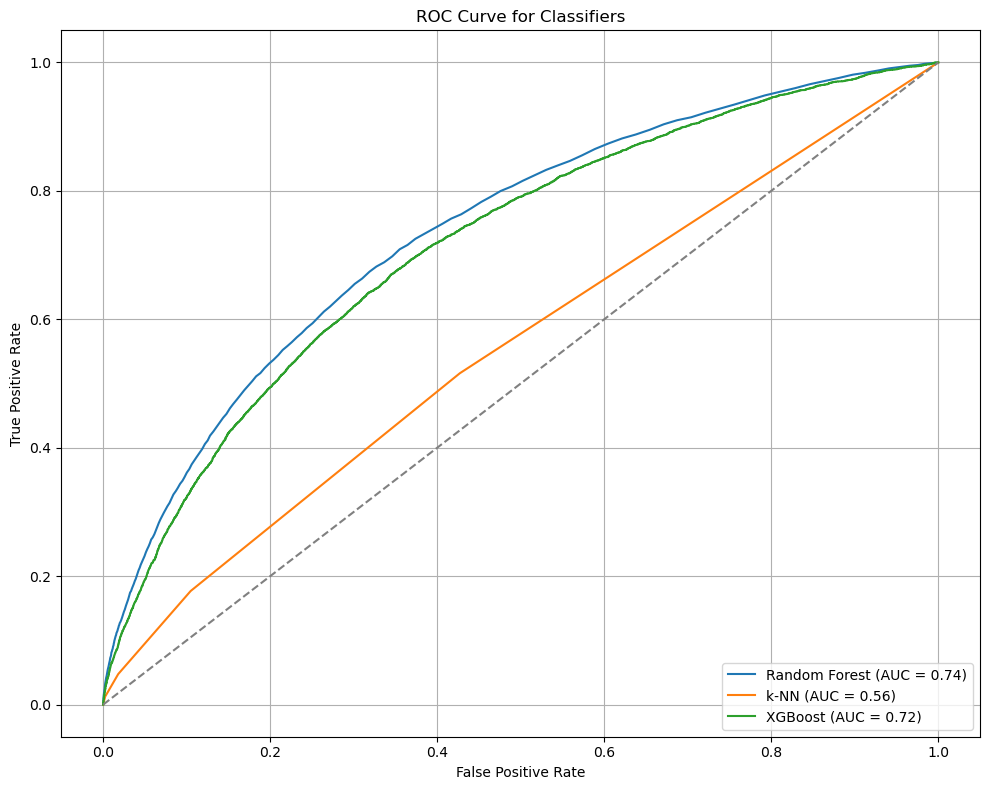

In [49]:
# Define a dictionary to store classifiers
classifiers = {
    'Random Forest': rf_classifier,
    'k-NN': knn_classifier4,
    'XGBoost': xgb_classifier,
    #'SVM': svm_classifier
}

# Create a figure for ROC curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its ROC curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve for each 
    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal (random guess line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('ROC Curve before SMOTE and Standardization.png')
plt.show()

### Precision - Recall Curve

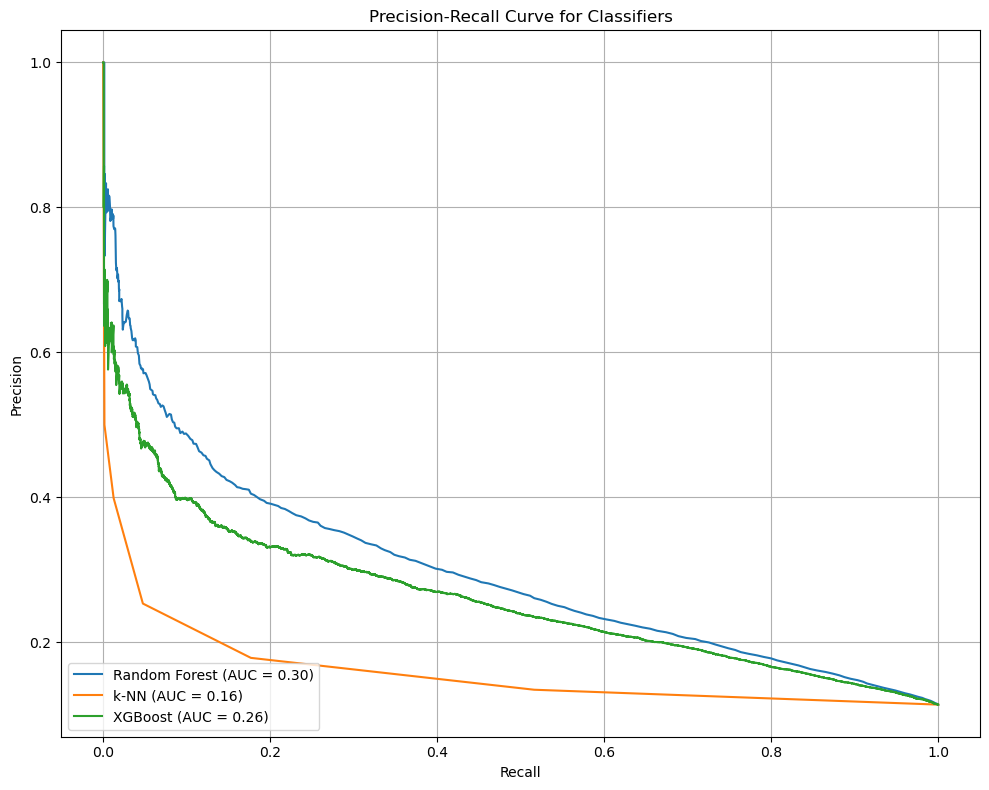

In [51]:
# Define a dictionary to store classifiers
classifiers = {
    'Random Forest': rf_classifier,
    'k-NN': knn_classifier4,
    'XGBoost': xgb_classifier,
    #'SVM': svm_classifier   
}

# Create a figure for PR curves
plt.figure(figsize=(10, 8))

# Iterate through each classifier and plot its PR curve
for clf_name, clf in classifiers.items():
    # Make predictions on the test set to obtain probabilities
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    # Calculate PR AUC score
    pr_auc = auc(recall, precision)
    
    # Plot PR curve for each classifier
    plt.plot(recall, precision, label=f'{clf_name} (AUC = {pr_auc:.2f})')

# Add labels and title to the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Classifiers')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.savefig('Precision-Recall before SMOTE and Standardization.png')
plt.show()